<div>
<img align="right" src="pictures/Logo.png" width="200"/>
</div>

# Persistent topological spectra tested on a real device

Kathrin König (kathrin.koenig@iaf.fraunhofer.de), Andreas Woitzik (andreas.woitzik@physik.uni-freiburg.de), Eric Brunner (eric.brunner@physik.uni-freiburg.de)

In [1]:
import numpy as np
import qtda_module as qtda
from qiskit.visualization import plot_histogram
from qiskit import IBMQ
from qiskit import execute, QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.compiler import transpile

In this notebook we test the quantum algorithm for the persistent topological analysis on real quantum hardware.

In [2]:
provider = IBMQ.load_account()
accountProvider = IBMQ.get_provider(hub='ibm-q-fraunhofer',group = 'fhg-all',project = 'ticket')
backend = accountProvider.get_backend('ibmq_brooklyn') 

## Quantum circuit for the topological analysis

As an example, the quantum circuit for the topological analysis of a simplicial complex of three abstract points is used.
<div>
<img src="pictures/Simplex_real-device.png" width="200"/>
</div>

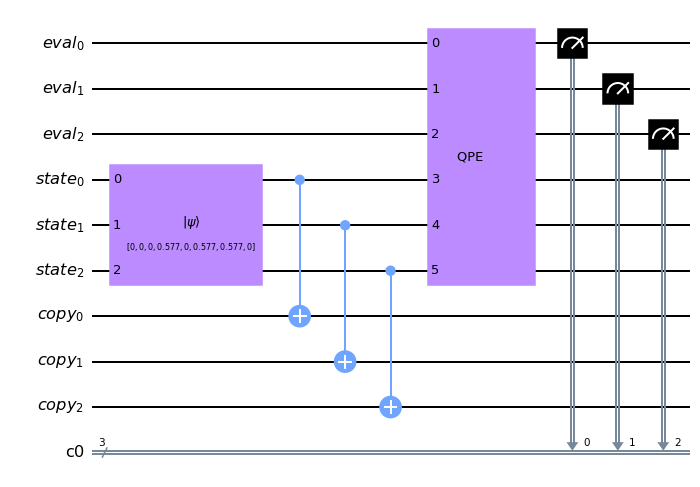

In [3]:
n_vertices = 3 # number of vertices
num_eval_qubits = 3 # number of evaluation qubits

S0 = [(0,0,1),(0,1,0), (1,0,0)] # points
S1 = [(1,0,1),(0,1,1),(1,1,0)] # lines
S2 = []

state_dict = {0: S0, 1: S1, 2: S2}
k = 1 # order of the combinatorial Laplacian
qc = qtda.QTDAalgorithm(num_eval_qubits, k, state_dict)

qc.add_register(ClassicalRegister(num_eval_qubits)) # adding a classical register for measuring
for q in qc.eval_qubits: # measure all evaluation qubits
    qc.measure(q,q)
qc.draw('mpl')

The circuit is transpiled to the basis gates set `'id', 'rz', 'sx', 'x' and 'cx'`, with the layout method `sabre` (reduces full routing cost) and optimization level 3 (heavy optimization).
The transpilation is done for an arbitrary backend and the `ibmq_brooklyn`.

In [4]:
qcc = transpile(qc, basis_gates=['id', 'rz', 'sx', 'x', 'cx'], layout_method='sabre',optimization_level=3)

In [5]:
qa = transpile(qc, backend=backend, basis_gates=['id', 'rz', 'sx', 'x', 'cx'],layout_method='sabre',optimization_level=3)

For quantum computers in the NISQ era, a high circuit depth amplifies the errors and is undesired. Because of the high circuit depth, we do expect a high noise level.

In [6]:
qa.depth() # depth of ibmq_brooklyn

1225

In [7]:
qcc.depth() # depth of an arbitrary backend

709

We estimate the number of 1-holes from the output counting statics, by adding measurements on the evaluation qubits (listed in qc.eval_qubits). The number of 1-holes, i.e. the first Betti-number $\beta_1$, is equal to the probability of measuring eigenvalue $0$ of $\Delta_1$ (i.e. the phase $\varphi = 0/2\pi = 0$ at the end of the QPE algorithm) times the dimension of the 1-simplex subspace

$$
\beta_1 = \dim \text{Eig}_0 \Delta_1 = | \lbrace s_1^i \rbrace_i | \; \text{Prob} \left( \frac{0}{2\pi} \right) = 3 \; \text{Prob} \left( \frac{0}{2\pi} \right)
$$

In the considered small example, we have three 1-simplices (edges) $S0 = [(1,0,1),(0,1,1),(1,1,0)]$.

In [8]:
shots = 8192
job = execute(qa, backend, shots=shots)
counts = job.result().get_counts(qa)

The number of 1-holes is 0.515625


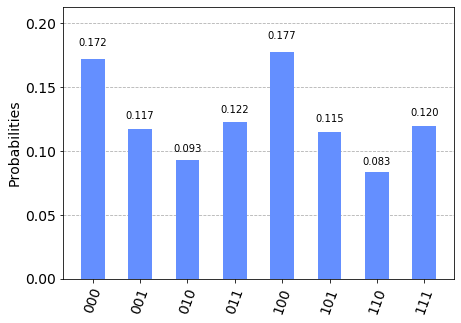

In [9]:
dim = len(state_dict[1]) # dimension of 1-simplex space
prob = counts.get("0"*num_eval_qubits)/shots # probability of eigenvalue 0

print('The number of 1-holes is', dim * prob)
plot_histogram(counts)

We obtain a result of $\sim 0.52$ 1-dimensional holes. Similar results were obtained from several runs of the algorithm on the real quantum hardware. Hence, the number of holes is, unfortunately, not correctly discovered.

As the algorithmon fails to converge with real quantum hardware, a more hardware efficient ansatz needs to be developed. No optimization of the circuit was conducted due to time reasons, but we see a large potential in circuit optimization.

In [10]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}